# Pair Selection via Cointegration

**Goal.** Select statistically valid pairs for market-neutral trading using the Engle–Granger approach and half-life diagnostics.

**Why cointegration (not correlation)?**
- **Correlation** can be high even when the price **spread drifts** over time (non-stationary ratio), i.e., no reliable mean-reversion anchor.
- **Cointegration** between two price series $X_t$ and $Y_t$ asserts there exists a linear combo
  $$S_t = Y_t - (\alpha + \beta X_t)$$
  that is **stationary**. If $S_t$ behaves like an OU-type process, it fluctuates around a mean and tends to revert.

**Method used (Engle–Granger 2-step):**
1. OLS: $Y_t = \alpha + \beta X_t + \varepsilon_t$
2. ADF test on residuals $\varepsilon_t$. Low p-values $\Rightarrow$ reject unit root $\Rightarrow$ residuals are stationary $\Rightarrow$ evidence of cointegration.

We also compute the **mean-reversion half-life** $t_{1/2} = \ln 2 / \kappa$ (for an OU-like dynamic) as a practical speed-of-reversion diagnostic.

**Outputs of this notebook**
- Full table of candidate pairs with: $(\alpha,\beta)$, ADF statistic, p-value, half-life, sample size.
- Optional multiple-testing control (Benjamini–Hochberg FDR).
- A ranked **Top-K** list saved to `data/interim/selected_pairs.parquet`, consumed by later notebooks.


We keep imports minimal and robust.  
This cell also makes sure `helpers.py` (written in notebook 00) is importable.


In [89]:
# Make helpers importable from the current /notebooks folder
import sys
from pathlib import Path
NB_DIR = Path.cwd()
if str(NB_DIR) not in sys.path:
    sys.path.insert(0, str(NB_DIR))

import numpy as np
import pandas as pd

from helpers import engle_granger, half_life  # from 00_setup_and_data


Parameters below can be tweaked.  
- `ADF_ALPHA` is the target false-positive rate per test (used for FDR as well).  
- `MIN_OVERLAP_DAYS` ensures we only test pairs with sufficient overlapping history.  
- `MAX_PAIRS` caps the final shortlist for downstream backtests.


In [90]:
DATA = NB_DIR.parent / "data"
INTERIM = DATA / "interim"

ADF_ALPHA = 0.05
MIN_OVERLAP_DAYS = 500
MAX_PAIRS = 20  # final shortlist size

# Load the cleaned price panel created in 00_setup_and_data
PRICES = pd.read_parquet(INTERIM / "prices_interim.parquet")
print("Prices shape:", PRICES.shape)
PRICES.tail(3)


Prices shape: (2475, 15)


Ticker,AAPL,AMZN,GOOGL,GS,JPM,KO,META,MSFT,NVDA,PEP,PG,TSLA,XLE,XLK,XLP
Date,,,,,,,,,,,,,,,
2025-10-31,270.369995,244.220001,281.190002,789.369995,311.119995,68.900002,648.349976,517.809998,202.490005,146.089996,150.369995,456.559998,88.129997,300.679993,76.279999
2025-11-03,269.049988,254.000000,283.720001,785.520020,309.350006,67.970001,637.710022,517.030029,206.880005,143.600006,148.020004,468.369995,88.139999,301.910004,75.680000
2025-11-05,270.035004,249.100006,283.364990,792.989990,312.049988,68.324997,639.702820,508.007812,201.437195,142.320007,146.389999,465.394989,87.714996,297.299988,76.021500


We consider **all unordered pairs** of columns in the prices wide frame.

**Important notes**
- We test only on **overlapping dates** to avoid accidental forward fills.
- We require at least `MIN_OVERLAP_DAYS` observations per pair to get meaningful statistics.
- Prices are used as-is (Adjusted Close). For cointegration, using prices (not returns) is typical because we test for a stationary *linear combination* of non-stationary series.


In [91]:
cols = list(PRICES.columns)
len(cols), cols[:15]


(15,
 ['AAPL',
  'AMZN',
  'GOOGL',
  'GS',
  'JPM',
  'KO',
  'META',
  'MSFT',
  'NVDA',
  'PEP',
  'PG',
  'TSLA',
  'XLE',
  'XLK',
  'XLP'])

For each pair (Y, X) we:

1) Fit OLS: $Y_t = \alpha + \beta X_t + \varepsilon_t$ using overlapping dates only.
2) Run ADF test on residuals $\varepsilon_t$.
3) Compute **half-life** on the derived spread $S_t = Y_t - (\alpha + \beta X_t)$.

We keep:
- `p_value` from ADF (lower is better),
- `half_life` in days (lower is faster mean-reversion),
- `n_obs` to monitor sample size.

**Caveat:** Low p-value is necessary but not sufficient. Half-life helps exclude pairs with statistically stationary residuals but **too slow** reversion to be tradable.


In [92]:
results = []
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        y, x = cols[i], cols[j]
        df = PRICES[[y, x]].dropna()
        if len(df) < MIN_OVERLAP_DAYS:
            continue
        a, b, adf_stat, pval, spread_series = engle_granger(df[y], df[x])
        hl = half_life(spread_series)
        results.append({
            "y": y, "x": x,
            "alpha": float(a), "beta": float(b),
            "adf_stat": float(adf_stat), "p_value": float(pval),
            "half_life": np.nan if hl is None else float(hl),
            "n_obs": int(len(df))
        })

pairs = pd.DataFrame(results)
print("Pairs tested:", len(pairs))
pairs.head(10)


Pairs tested: 105


,y,x,alpha,beta,adf_stat,p_value,half_life,n_obs
0,AAPL,AMZN,-22.265479,1.129011,-2.106279,0.241997,193.231072,2475
1,AAPL,GOOGL,-17.974883,1.340409,-1.653542,0.455194,211.691149,2475
2,AAPL,GS,-8.674774,0.416409,-1.758822,0.401089,272.006966,2475
3,AAPL,JPM,-15.414011,1.025250,-1.815219,0.372933,241.341851,2475
4,AAPL,KO,-159.485115,5.741369,-3.400109,0.010955,67.369958,2475
5,AAPL,META,16.883722,0.347754,-1.850935,0.355483,335.684846,2475
6,AAPL,MSFT,0.882444,0.506784,-3.583161,0.006091,83.703819,2475
7,AAPL,NVDA,71.114941,1.208955,-1.529120,0.519060,338.815866,2475
8,AAPL,PEP,-137.604443,2.032609,-0.861045,0.800530,270.632023,2475
9,AAPL,PG,-106.853001,1.952553,-1.919460,0.322963,84.164926,2475


We apply **basic sanity filters** before any multiple-testing adjustment:

- Drop rows with missing `p_value` or `half_life`.
- Keep only pairs with positive `n_obs` (already enforced) and reasonable `half_life` (e.g., >0).
- Sort by `(p_value ASC, half_life ASC)` to prioritize stronger stationarity and faster reversion.

This is a **pre-ranking** step.


In [93]:
filtered = (
    pairs.dropna(subset=["p_value", "half_life"])
         .query("half_life > 0")
         .sort_values(["p_value", "half_life"], ascending=[True, True])
         .reset_index(drop=True)
)

print("After basic filters:", filtered.shape)
filtered.head(10)


After basic filters: (91, 8)


,y,x,alpha,beta,adf_stat,p_value,half_life,n_obs
0,TSLA,XLP,-346.021602,8.444825,-3.898149,0.002049,85.155939,2475
1,KO,TSLA,36.056034,0.077242,-3.788443,0.003028,95.303207,2475
2,KO,MSFT,29.620229,0.080560,-3.659847,0.004715,66.768381,2475
3,AAPL,MSFT,0.882444,0.506784,-3.583161,0.006091,83.703819,2475
4,AAPL,KO,-159.485115,5.741369,-3.400109,0.010955,67.369958,2475
5,AAPL,XLP,-190.820873,5.204812,-3.242557,0.017650,49.694564,2475
6,PG,TSLA,77.270617,0.239493,-3.221256,0.018787,101.163155,2475
7,KO,XLK,27.085975,0.167130,-3.153693,0.022827,75.286774,2475
8,TSLA,XLK,-61.298078,1.709575,-3.096067,0.026846,119.332608,2475
9,AAPL,TSLA,36.647891,0.518440,-3.027208,0.032431,86.471784,2475


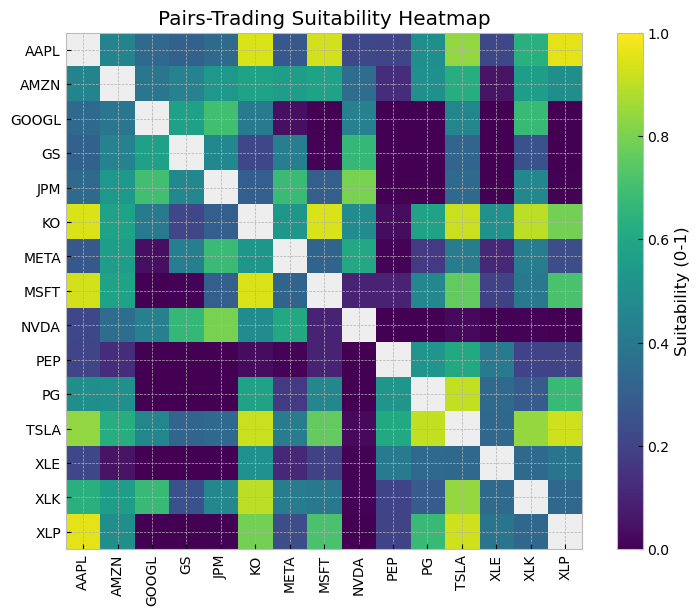

In [94]:
# --- Heatmap of pairs-trading suitability ---

tbl = pairs.copy()  # or filtered, or filtered[filtered["fdr_keep"]]

# suitability in [0,1]
p = tbl["p_value"].clip(lower=1e-16, upper=1.0)
sp = -np.log10(p)
lo, hi = np.nanpercentile(sp, [5, 95])
sp = ((sp - lo) / (hi - lo)).clip(0.0, 1.0)

hl = tbl["half_life"].replace([np.inf, -np.inf], np.nan)
hl_cap = np.nanpercentile(hl, 90) if np.isfinite(hl).any() else 1.0
sh = (1.0 - (hl / hl_cap)).clip(0.0, 1.0)

tbl["suitability"] = (0.6 * sp + 0.4 * sh).fillna(0.0)

tickers = sorted(PRICES.columns.tolist())
M = pd.DataFrame(np.nan, index=tickers, columns=tickers)

for _, r in tbl.iterrows():
    y, x, s = str(r["y"]), str(r["x"]), float(r["suitability"])
    if y in M.index and x in M.columns:
        M.loc[y, x] = s
        M.loc[x, y] = s

np.fill_diagonal(M.values, np.nan)

fig, ax = plt.subplots(
    figsize=(min(12, 1.0 + 0.45 * len(tickers)),
             min(10, 1.0 + 0.35 * len(tickers)))
)
masked = np.ma.masked_invalid(M.to_numpy())
im = ax.imshow(masked, cmap="viridis", vmin=0.0, vmax=1.0)

ax.set_xticks(np.arange(len(tickers))); ax.set_yticks(np.arange(len(tickers)))
ax.set_xticklabels(tickers, rotation=90); ax.set_yticklabels(tickers)
ax.set_title("Pairs-Trading Suitability Heatmap")
cbar = plt.colorbar(im, ax=ax); cbar.set_label("Suitability (0-1)")

if len(tickers) <= 14:
    for i in range(len(tickers)):
        for j in range(len(tickers)):
            v = M.iat[i, j]
            if np.isfinite(v):
                ax.text(j, i, f"{v:.2f}", ha="center", va="center", fontsize=8, color="white")

plt.tight_layout()
plt.show()


When scanning many pairs, some significant results will appear **by chance**.  
We therefore apply **Benjamini–Hochberg (FDR)** to control the **expected false discovery rate** among selected pairs.

**BH rule** (intuitive):
- Sort p-values ascending: $p_{(1)} \le \dots \le p_{(n)}$.
- Find largest $k$ with $p_{(k)} \le \alpha \cdot k/n$.
- Keep pairs with ranks $\le k$.

This preserves power better than strict Bonferroni and is commonly used in finance research when testing many alphas/pairs.


In [95]:
# --- Benjamini–Hochberg (FDR) procedure ---
MAX_PAIRS = 5
def fdr_bh(pvals: np.ndarray, alpha: float = 0.05) -> np.ndarray:
    p = np.asarray(pvals, float)
    n = p.size
    if n == 0:
        return np.zeros(0, dtype=bool)
    order = np.argsort(p)
    ranked = p[order]
    thresh = alpha * (np.arange(1, n + 1) / n)
    passed = ranked <= thresh
    mask = np.zeros(n, dtype=bool)
    if passed.any():
        k = np.where(passed)[0].max() + 1
        mask[order[:k]] = True
    return mask

# --- Apply BH and fallback if empty ---
mask = fdr_bh(filtered["p_value"].values, alpha=ADF_ALPHA)
filtered["fdr_keep"] = mask

# If BH selects nothing, fallback to top pairs by p_value
if not filtered["fdr_keep"].any():
    print("No pairs passed FDR — using top pairs by smallest p_value.")
    filtered["fdr_keep"] = False
    filtered.loc[filtered.sort_values("p_value").head(MAX_PAIRS).index, "fdr_keep"] = True

# Display filtered pairs with fdr_keep flag
filtered.head(10)


No pairs passed FDR — using top pairs by smallest p_value.


,y,x,alpha,beta,adf_stat,p_value,half_life,n_obs,fdr_keep
0,TSLA,XLP,-346.021602,8.444825,-3.898149,0.002049,85.155939,2475,True
1,KO,TSLA,36.056034,0.077242,-3.788443,0.003028,95.303207,2475,True
2,KO,MSFT,29.620229,0.080560,-3.659847,0.004715,66.768381,2475,True
3,AAPL,MSFT,0.882444,0.506784,-3.583161,0.006091,83.703819,2475,True
4,AAPL,KO,-159.485115,5.741369,-3.400109,0.010955,67.369958,2475,True
5,AAPL,XLP,-190.820873,5.204812,-3.242557,0.017650,49.694564,2475,False
6,PG,TSLA,77.270617,0.239493,-3.221256,0.018787,101.163155,2475,False
7,KO,XLK,27.085975,0.167130,-3.153693,0.022827,75.286774,2475,False
8,TSLA,XLK,-61.298078,1.709575,-3.096067,0.026846,119.332608,2475,False
9,AAPL,TSLA,36.647891,0.518440,-3.027208,0.032431,86.471784,2475,False


We now form the final shortlist:

1) Prefer pairs that pass FDR (`fdr_keep=True`).
2) If fewer than `MAX_PAIRS` pass, fill the remainder from the pre-sorted list.
3) Save both the **full table** and the **selected shortlist** for downstream notebooks.

Saved files:
- `data/interim/pairs_cointegration.parquet` — all filtered pairs with diagnostics.
- `data/interim/selected_pairs.parquet` — Top-K shortlist (columns: y, x, alpha, beta, p_value, half_life, n_obs).


In [96]:
ALL_OUT = filtered.copy()
ALL_OUT.to_parquet(INTERIM / "pairs_cointegration.parquet")

if filtered["fdr_keep"].sum() >= MAX_PAIRS:
    selected = filtered.loc[filtered["fdr_keep"]].copy()
    selected = selected.sort_values(["p_value", "half_life"], ascending=[True, True]).head(MAX_PAIRS)
else:
    selected = filtered.head(MAX_PAIRS).copy()

selected = selected.reset_index(drop=True)

# Keep only essential columns for downstream use
selected_min = selected[["y","x","alpha","beta","adf_stat","p_value","half_life","n_obs"]].copy()
selected_min.to_parquet(INTERIM / "selected_pairs.parquet")

print("Selected pairs:", len(selected_min))
selected_min


Selected pairs: 5


,y,x,alpha,beta,adf_stat,p_value,half_life,n_obs
0,TSLA,XLP,-346.021602,8.444825,-3.898149,0.002049,85.155939,2475
1,KO,TSLA,36.056034,0.077242,-3.788443,0.003028,95.303207,2475
2,KO,MSFT,29.620229,0.080560,-3.659847,0.004715,66.768381,2475
3,AAPL,MSFT,0.882444,0.506784,-3.583161,0.006091,83.703819,2475
4,AAPL,KO,-159.485115,5.741369,-3.400109,0.010955,67.369958,2475


A quick sanity check for the **top pair**:
- Plot the **spread** $S_t = Y_t - (\alpha + \beta X_t)$
- Overlay its **z-score** (on a separate axis scale)
  
This is not a full trading signal yet (that comes later), but it visually confirms mean-reversion characteristics.


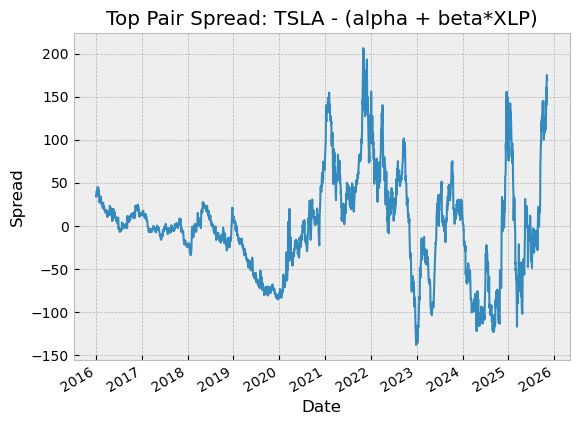

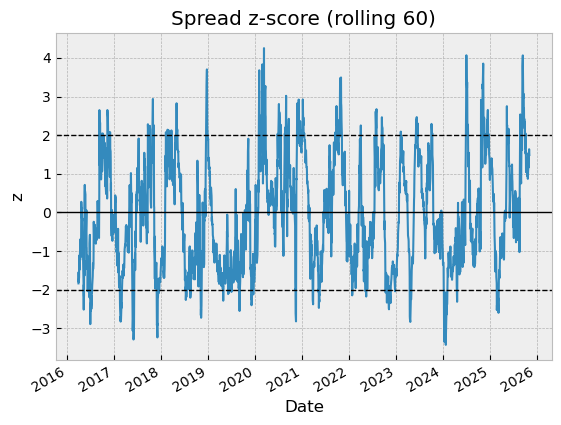

In [97]:
import matplotlib.pyplot as plt
from helpers import spread, rolling_zscore
plt.style.use('bmh')

if len(selected_min) > 0:
    top = selected_min.iloc[0]
    y, x = top["y"], top["x"]
    a, b = float(top["alpha"]), float(top["beta"])
    df = PRICES[[y, x]].dropna()
    S = spread(df[y], df[x], beta=b, alpha=a)
    Z = rolling_zscore(S, window=60)

    plt.figure()
    S.plot(lw=1.5, title=f"Top Pair Spread: {y} - (alpha + beta*{x})")
    plt.xlabel("Date"); plt.ylabel("Spread")
    plt.show()

    plt.figure()
    Z.plot(lw=1.50, title="Spread z-score (rolling 60)")
    plt.axhline(0, c='k', lw=1); plt.axhline(2, linestyle="--", c='k', lw=1); plt.axhline(-2, linestyle="--", c='k', lw=1)
    plt.xlabel("Date"); plt.ylabel("z")
    plt.show()
else:
    print("No pairs selected; consider loosening filters or enlarging the universe.")


# Summary

**What we did**
1. Scanned all ticker pairs in the cleaned price panel.
2. For each pair ran **Engle–Granger**:
   - OLS to estimate $(\alpha, \beta)$
   - ADF test on residuals to assess stationarity (cointegration evidence).
3. Computed **half-life** as a practical mean-reversion speed metric.
4. Applied basic sanity filters and **Benjamini–Hochberg FDR** to control the false discovery rate.
5. Produced a ranked **Top-K shortlist** of candidate pairs and saved:
   - `data/interim/pairs_cointegration.parquet` (full diagnostics)
   - `data/interim/selected_pairs.parquet` (final shortlist)

**Why this matters**
- Cointegration provides a statistically defensible anchor for mean-reversion trading.
- Half-life and FDR address, respectively, **tradability** and **multiple-testing** risks.

**Next notebook (02 — Signal & Risk)**
- Construct standardized spread $Z_t$.
- Define entry/exit/stop rules.
- Implement volatility-targeted position sizing.
